In [1]:
import numpy as np
import xarray as xr

from intake import open_catalog
from dataclasses import dataclass
from typing import Iterable, Optional

In [2]:
'''
Uses existing variables and stencilled variables to prevent duplicate stencilling.
ML training/modelling methods should be added in here.

Parameters:
    variable: list(Variable) - list of variables (with stencil data) to add to training input
    name: str - The name (or "label") of the scenario
'''
@dataclass
class Scenario:
    conv_var: Iterable[str]
    input_var: Iterable[str]
    target: Iterable[str]
    name: str

In [3]:
target = ['U', 'V']

In [4]:
# Scenarios from 2d stencil notebook (re-expand maybe)
sc1 = Scenario(['SSH'],             ['TAUX', 'TAUY'], target, name = "derp")
sc5 = Scenario(['SSH', 'SST'], ['X', 'TAUX', 'TAUY'], target, name = "herp")

In [5]:
def add_grid(ds):
    
    X = lambda lat: np.sin(np.radians(lat))
    Y = lambda lat, lon:  np.cos(np.radians(lat)) * np.sin(np.radians(lon))
    Z = lambda lat, lon: -np.cos(np.radians(lat)) * np.cos(np.radians(lon))
    delta = lambda dx, dxMean, dxStd: (dx - dxMean)/dxStd
    
    lats = ds.YU.data
    lons = ds.XU.data
    DX = ds.DXT.data
    DY = ds.DYT.data
    
    x = X(lats)
    y = Y(lats, lons)
    z = Z(lats, lons)
    dX = delta(DX, np.mean(DX), np.std(DX))
    dY = delta(DY, np.mean(DY), np.std(DY))

    ds['X']  = ds.XU.dims, x
    ds['Y']  = ds.XU.dims, y
    ds['Z']  = ds.XU.dims, z
    ds['dx'] = ds.XU.dims, dX
    ds['dy'] = ds.XU.dims, dY
    
    return(ds)    

In [6]:
def get_mask_from(ds, x):
    return ~np.isnan(ds[x])

In [7]:
def prepare_data_2D(sc, training_time, test_time, predict_time, mask_time=11):
    cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
    ds  = cat["CESM_POP_hires_control"].to_dask()
    ds = ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})
    ds = add_grid(ds)

    mask1 = get_mask_from(ds, 'SSH')[{'time':mask_time}]
    mask2 = get_mask_from(ds, 'TAUY')[{'time':mask_time}]
    mask3 = get_mask_from(ds, 'U')[{'time':mask_time}]
    mask = mask1 & mask2 & mask3
    mask = mask.compute()
    
    varList = sc.conv_var + sc.input_var + sc.target
    ds = ds[varList]
    ds['mask'] = mask
    
    ds_training = ds.isel(time = training_time)
    ds_training.to_zarr('scenarios/', group = 'training_' + sc.name + '.zarr', mode = 'w')
    del ds_training
    
    ds_test     = ds.isel(time =     test_time)
    ds_test.to_zarr('scenarios/',     group = 'test_'     + sc.name + '.zarr', mode = 'w')
    del ds_test
    
    ds_predict  = ds.isel(time =  predict_time)
    ds_predict.to_zarr('scenarios/',  group = 'predict_'  + sc.name + '.zarr', mode = 'w')
    del ds_predict
    
    pass

In [166]:
prepare_data_2D(sc5, 200, 1000, 1000, 200)

In [8]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import gc

In [9]:
def filter_none(xs):
    return list(filter(lambda x: x is not None, xs))

In [10]:
def loader(sc, name):
    ds = xr.open_zarr('scenarios/', group = name + '_' + sc.name + '.zarr')
    return ds

def load_training_data(sc):
    return loader(sc, 'training')

def load_test_data(sc):
    return loader(sc, 'test')

def load_predict_data(sc):
    return loader(sc, 'predict')

In [11]:
import tensorflow as tf

2023-01-20 04:29:37.969773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [155]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self, frequency=2048):
        self.frequency = frequency
        self.batch_counter = 0
        
        self.i = 0
        self.x = []
        self.mae = []
        self.mse = []
        self.accuracy = []
        self.logs = []
        
    def on_train_begin(self, logs={}):
        self.fig = plt.figure()
        
    def on_batch_end(self, batch, logs={}):
        # if batch % self.frequency == 0:
        self.batch_counter += self.frequency
        self.x.append(self.i)
        self.mae.append(logs.get('mae'))
        self.mse.append(logs.get('mse'))
        self.accuracy.append(logs.get('accuracy'))

        self.i += 1
            
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        clear_output(wait=True)
        print(f"MAE: {self.mae[-1]} \t\t MSE: {self.mse[-1]} \t\t Accuracy: {self.accuracy[-1]}")
        
        plt.figure(figsize=(18,5))

        plt.subplot(131)
        plt.plot(self.x, self.mae, color='#ff6347',label="mae")
        plt.plot(self.x[-1], self.mae[-1],marker = 'o', markersize=10, color='#ff6347')
        plt.legend()
        plt.xlabel(r'batch');
        plt.ylabel('Mean Absolute Error');
        plt.ylim([0.,100.])

        plt.subplot(132)
        plt.plot(self.x, self.mse, color='#6495ed')
        plt.plot(self.x[-1], self.mse[-1],marker = 'o', markersize=10, color='#6495ed')
        plt.xlabel('batch')
        plt.ylabel(r'Mean Squared Error [$cm^2/s^2$]')
        plt.ylim([0.,1000.])

        plt.subplot(133)
        plt.plot(self.x, self.accuracy, color='#3cb371')
        plt.plot(self.x[-1], self.accuracy[-1],marker = 'o', markersize=10, color='#3cb371')
        plt.xlabel('batch')
        plt.ylabel('Model Accuracy')
        plt.ylim([0.,1.])

        plt.show()

In [156]:
ds_training = load_training_data(sc5)

In [157]:
ds_training = ds_training.isel(nlon=list(range(2000,2640)), nlat=list(range(1000,1640)))

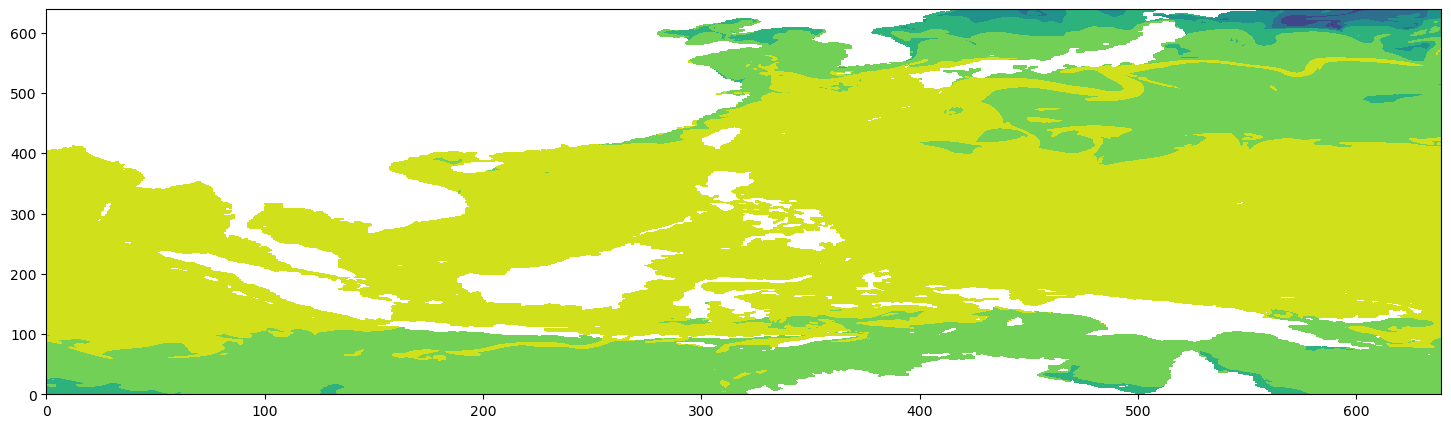

In [158]:

plt.figure(figsize=(18,5))
plt.contourf(ds_training['SST'])
plt.show()

In [159]:
import xbatcher as xb

In [160]:
# Corner case: what happens when everything is NaN?
class Grid_MAE(tf.keras.losses.Loss):        
    def call(self, y_true, y_pred):
        avg = tf.math.abs(y_true - y_pred)
        masked = tf.where(tf.math.is_finite(avg), avg, tf.zeros_like(avg))
        return tf.math.reduce_sum(masked)

In [163]:
def train(ds, sc, conv_dims=[5,5], nfilters=40, conv_kernels=[5], dense_layers=3):

    halo_size = int((np.sum(conv_kernels) - len(conv_kernels))/2)
    halo_dims = [x - 2*halo_size for x in conv_dims]
    
    nlons, nlats = conv_dims

    bgen = xb.BatchGenerator(
        ds,
        {'nlon':nlons,     'nlat':nlats}#,
        #{'nlon':halo_size, 'nlat':halo_size}
    )
    
    sub = {'nlon':range(halo_size,nlons-halo_size),
           'nlat':range(halo_size,nlats-halo_size)}

    
    conv_init = tf.keras.Input(shape=tuple(conv_dims) + (len(sc.conv_var),))
    last_layer = tf.keras.layers.Conv2D(nfilters, conv_kernels[0])(conv_init)
    for kernel in conv_kernels[1:]:
        nfilters = nfilters / 2.
        this_layer = tf.keras.layers.Conv2D(nfilters, kernel)(last_layer)
        last_layer = this_layer
    
    input_init = tf.keras.Input(shape=tuple(halo_dims) + (len(sc.input_var),))
    last_layer = tf.keras.layers.concatenate([last_layer, input_init])
    #last_layer = tf.keras.layers.Conv2D(nfilters, 2)(last_layer)
    #last_layer = tf.keras.layers.Reshape((nfilters+3,))(last_layer)
    last_layer = tf.keras.layers.LeakyReLU(alpha=0.3)(last_layer)
    for layer in range(dense_layers):
        nfilters = nfilters / 2.
        this_layer = tf.keras.layers.Dense(nfilters, activation='relu')(last_layer)
        last_layer = this_layer
        
    output_layer = tf.keras.layers.Dense(len(sc.target))(last_layer)
    
    model = tf.keras.Model(inputs=[conv_init, input_init], outputs=output_layer)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss=Grid_MAE(), optimizer=opt, metrics=['mae', 'mse', 'accuracy'])
    #model.summary()

    history = LossHistory()
    for batch in bgen:
        batch = batch.expand_dims("sample").transpose('sample','nlat','nlon')

        batch_conv   = [batch[x] for x in sc.conv_var]
        batch_input  = [batch[x][sub] for x in sc.input_var]
        batch_target = [batch[x][sub] for x in sc.target]
        batch_conv   = xr.merge(batch_conv).to_array('var').transpose(...,'var')
        batch_input  = xr.merge(batch_input).to_array('var').transpose(...,'var')
        batch_target = xr.merge(batch_target).to_array('var').transpose(...,'var')
        
        model.fit([batch_conv, batch_input],
                  batch_target,
                  batch_size=32, epochs=1, verbose=0,
                  callbacks=[history])
        clear_output(wait=True)

    model.save('models/'+ sc.name)
    np.savez('models/history_'+sc.name, losses=history.mae, mse=history.mse, accuracy=history.accuracy)

    return model, history
    

In [ ]:
train(ds_training, sc5)